In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import seaborn as sns
import re
from nltk.corpus import stopwords 
from collections import Counter
from torch.utils.data import TensorDataset, DataLoader, Dataset
import torch.nn as nn
from tqdm.auto import tqdm
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from keras.layers import Dense, Input, Flatten, LSTM, Bidirectional,Embedding, Dropout
from keras.layers import Conv1D, MaxPooling1D, Embedding
from keras.models import Sequential, load_model
from keras import losses
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from keras.preprocessing.sequence import pad_sequences
from keras.utils import plot_model
from keras.callbacks import EarlyStopping
import torch

In [18]:
base_csv = '/kaggle/input/arabic-news-data/arabic_news_data.csv'
data = pd.read_csv(base_csv)

# Exploaration data

In [19]:
data.head()

,Unnamed: 0,text,score
0,0,وقالت لجنه نوبل للمره الاولي التاريخ يمكن الان...,9
1,1,نشرت الوكاله وثاءق علي الانترنت اعدها موظفوها ...,9
2,2,دراسه حديثه قام فريق العلماء جونز هوبكنز ميديس...,9
3,3,دعا الاتحاد الاوروبي الرءيس الاميركي جو بايدن ...,9
4,4,وتعمل الوكاله علي اطلاق مركبه فضاءيه الي كوكب ...,9


In [20]:
data = data.loc[:, ["text", "score"]]

In [21]:
data.shape

(13166, 2)

In [22]:
data['score'].unique()

array([9, 5, 3, 8, 7, 2, 6, 1, 4])

In [23]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13166 entries, 0 to 13165
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    13166 non-null  object
 1   score   13166 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 205.8+ KB


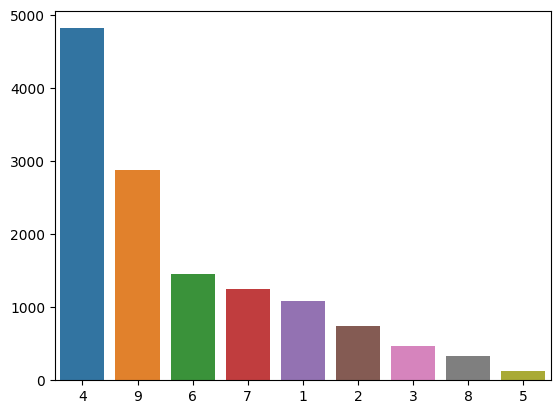

In [24]:
d = pd.Series(data['score'].values).value_counts()
sns.barplot(x=np.array(['4','9','6','7','1','2','3','8','5']),y=d.values)
plt.show()

## Splitting to train and test data

In [25]:
X,y = data['text'].values,data['score'].values
x_train,x_test,y_train,y_test = train_test_split(X,y,stratify=y)
print(f'shape of train data is {x_train.shape}')
print(f'shape of test data is {x_test.shape}')

shape of train data is (9874,)
shape of test data is (3292,)


## Tockenization

In [26]:
def preprocess_string(s):
    # Remove all non-word characters (everything except numbers and letters)
    s = re.sub(r"[^\w\s]", '', s)
    # Replace all runs of whitespaces with no space
    s = re.sub(r"\s+", '', s)
    # replace digits with no space
    s = re.sub(r"\d", '', s)

    return s

def tockenize(x_train,y_train,x_val,y_val):
    word_list = []

    stop_words = set(stopwords.words('arabic')) 
    for sent in x_train:
        for word in sent.lower().split():
            word = preprocess_string(word)
            if word not in stop_words and word != '':
                word_list.append(word)
                
    #print(word_list[:10])
    corpus = Counter(word_list)
    # sorting on the basis of most common words
    corpus_ = sorted(corpus,key=corpus.get,reverse=True)[:1000]
    # creating a dict
    onehot_dict = {w:i+1 for i,w in enumerate(corpus_)}
    
   
    max_len = max(map(len, x_train))
    max_len=500
    #print(max_len) =9854
    # tockenize
    final_list_train,final_list_test = [],[]
    for sent in x_train:
        tokenized_sent = [onehot_dict[preprocess_string(word)] for word in sent.lower().split()
                          if preprocess_string(word) in onehot_dict.keys()]
        # Pad the sequence to the maximum length
        padded_sent = [0] * (max_len - len(tokenized_sent)) +tokenized_sent
        final_list_train.append(padded_sent)

    for sent in x_val:
        tokenized_sent = [onehot_dict[preprocess_string(word)] for word in sent.lower().split()
                          if preprocess_string(word) in onehot_dict.keys()]
        # Pad the sequence to the maximum length
        padded_sent = [0] * (max_len - len(tokenized_sent)) +tokenized_sent
        final_list_test.append(padded_sent)
            
   
    return np.array(final_list_train), np.array(y_train),np.array(final_list_test), np.array(y_test),onehot_dict


In [27]:
x_train,y_train,x_test,y_test,vocab = tockenize(x_train,y_train,x_test,y_test)

## Batching and loading as tensor

In [28]:
class CommonLitReadabiltyDataset(Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.y = Y
        
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx], self.X[idx][1]
    
train_ds = CommonLitReadabiltyDataset(x_train, y_train)
test_ds = CommonLitReadabiltyDataset(x_test, y_test)

In [29]:
train_data = TensorDataset(torch.from_numpy(x_train), torch.from_numpy(y_train))
test_data = TensorDataset(torch.from_numpy(x_test), torch.from_numpy(y_test))

# dataloaders
batch_size = 64

# make sure to SHUFFLE your data
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
test_loader = DataLoader(test_data, shuffle=True, batch_size=batch_size)

train_dl = DataLoader(train_ds, shuffle=True, batch_size=batch_size)
test_dl = DataLoader(test_ds, shuffle=True, batch_size=batch_size)


In [30]:
#for i, item in enumerate(train_dl):
  #if i < 5:
   # print(item)

## Model

In [31]:
# hyper parameters
batch_size = 64
vocab_size=5000
#vocab_size = len(vocab)
embedding_dim = 300
hidden_dim = 200

In [32]:
class LSTM_regr(torch.nn.Module) :
    def __init__(self, vocab_size, embedding_dim, hidden_dim) :
        super().__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.linear = nn.Linear(hidden_dim, 1)
        self.dropout = nn.Dropout(0.3)
        
    def forward(self, x, l):
        x = self.embeddings(x)
        x = self.dropout(x)
        lstm_out, (ht, ct) = self.lstm(x)
        return self.linear(ht[-1])

In [33]:
model =  LSTM_regr(vocab_size, embedding_dim, hidden_dim)

## Training

In [34]:
def train_model_regr(model, epochs=10, lr=0.001):
    parameters = filter(lambda p: p.requires_grad, model.parameters())
    optimizer = torch.optim.Adam(parameters, lr=lr)
    train_losses = []  # Store training losses
    val_losses = []    # Store validation losses
    for i in range(epochs):
        model.train()
        sum_loss = 0.0
        total = 0
        for x, y ,l in train_dl:
            x = x.long()
            y = y.float()
            l = torch.full((batch_size,), 500, dtype=torch.int64)
            #print('x=',x.dtype)
            #print('l=',l.dtype)
            #print('y=',y.dtype)
            y_pred = model(x, l)
            #print('y_pred=',y_pred)
            optimizer.zero_grad()
            loss = F.mse_loss(y_pred, y.unsqueeze(1))
         
            loss.backward()
            optimizer.step()
            sum_loss += loss.item()*y.shape[0]
            total += y.shape[0]
        val_loss = validation_metrics_regr(model, test_dl)
        
        train_losses.append(sum_loss / total)  # Append training loss for this epoch
        val_losses.append(val_loss) 
        
        #if i % 5 == 1:
        print(f"========================================================== Epoche {i} ==========================================================")
        print("train mse %.3f val rmse %.3f" % (sum_loss/total, val_loss))
            
            
    plt.plot(range(1, epochs + 1), train_losses, label='Training Loss')
    plt.plot(range(1, epochs + 1), val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

def validation_metrics_regr (model, test_dl):
    model.eval()
    correct = 0
    total = 0
    sum_loss = 0.0
    for x, y ,l in test_dl:
        x = x.long()
        y = y.float()
        l = torch.full((batch_size,), 500, dtype=torch.int64)
        y_hat = model(x, l)
        loss = np.sqrt(F.mse_loss(y_hat, y.unsqueeze(-1)).item())
        total += y.shape[0]
        sum_loss += loss.item()*y.shape[0]
    return sum_loss/total

================================== Epoche 0 ======================================
train mse 4.946 val rmse 1.466
================================== Epoche 1 ======================================
train mse 1.671 val rmse 1.262
================================== Epoche 2 ======================================
train mse 1.379 val rmse 1.276
================================== Epoche 3 ======================================
train mse 1.223 val rmse 1.214
================================== Epoche 4 ======================================
train mse 1.141 val rmse 1.224
================================== Epoche 5 ======================================
train mse 0.995 val rmse 1.212
================================== Epoche 6 ======================================
train mse 0.890 val rmse 1.223
================================== Epoche 7 ======================================
train mse 0.798 val rmse 1.227
================================== Epoche 8 ======================================
train

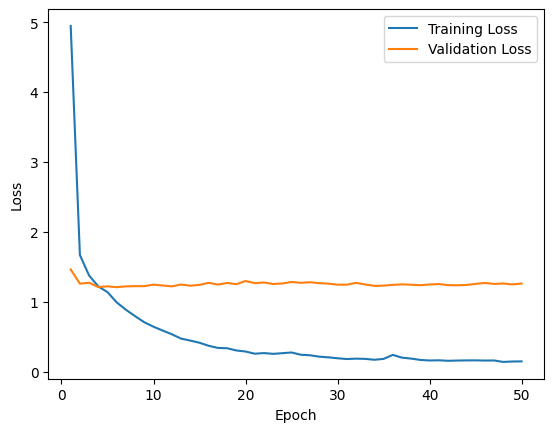

In [35]:
train_model_regr(model, epochs=50, lr=0.003)

## Evaluation